In [54]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import scriptinit
import numpy as np
import numpy.random as npr
import numpy.linalg as npla
from matplotlib.pyplot import *
from pyrl.algorithms.uvfa import *
from pyrl.algorithms.valueiter import *
from pyrl.tasks.gridworld import *
from pyrl.algorithms.nn import *
from pyrl.agents.agent import *
from pyrl.agents.multitask import *
from pyrl.algorithms.multitask import *
import pyrl.agents.arch as arch
from pyrl.prob import *
from pyrl.utils import *

In [55]:
def showV(v):
    imshow(v.reshape(H, W), interpolation='none')
    axis('off')
    print v

# UVFA

We first set up a neural network architecture that could learn multiple tasks simultaneously on the same world.

We use **end-to-end** training.

## World 1

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


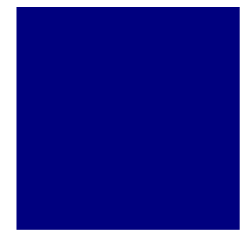

In [18]:
H = W = 6
grid = np.zeros((H, W))
showV(grid)

In [43]:
all_tasks = generate_gridworlds(grid)
random.shuffle(all_tasks)
task_inds = npr.choice(range(len(all_tasks)), 5, replace=False)
tasks = [all_tasks[ind] for ind in task_inds]
(train_tasks, test_tasks) = train_test_split(tasks, 0.7)

In [44]:
# evaluation function.
reconV = {}
for task in tasks:
    reconV[task] = compute_tabular_values([task])[:,0].reshape(H, W)
def eval_dataset(dqn, tasks):
    error = 0.0
    for task in tasks:
            myV = compute_Qfunc_V(dqn, task).reshape(H, W)
            error += np.mean([np.abs(myV[pos] - reconV[task][pos]) for pos in task.env.free_pos])
    return error / len(tasks)

## Try two layer architecture (baseline that does not work)

In [46]:
dqn = DQN(tasks[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
learner = SingleLearnerSequential(dqn, train_tasks, lr=1e-4, memory_size=250)

it 0 train_err 0.304544208034 test_err 0.256414190205
it 1 train_err 0.351052272149 test_err 0.278129777295
it 2 train_err 0.198534244385 test_err 0.167607604848
it 3 train_err 0.232791948984 test_err 0.174591641847
it 4 train_err 0.206003191024 test_err 0.162150613867
it 5 train_err 0.168146374755 test_err 0.152116670026
it 6 train_err 0.185306179059 test_err 0.160331333326
it 7 train_err 0.15841647076 test_err 0.157393939707
it 8 train_err 0.144032495858 test_err 0.154771427442
it 9 train_err 0.13833544872 test_err 0.154237986206
it 10 train_err 0.15084529602 test_err 0.152575104854
it 11 train_err 0.143056996282 test_err 0.149845503013
it 12 train_err 0.132545165097 test_err 0.153886502012
it 13 train_err 0.139127222357 test_err 0.149815430408
it 14 train_err 0.108412068385 test_err 0.151587133529
it 15 train_err 0.11430665133 test_err 0.152633929404
it 16 train_err 0.107857829157 test_err 0.15132482793
it 17 train_err 0.0941596838458 test_err 0.156672090443
it 18 train_err 0.088793

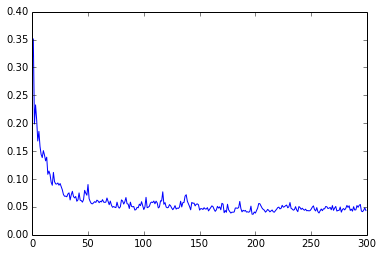

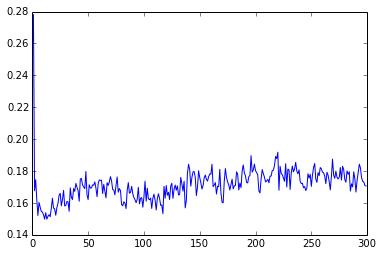

In [47]:
train_errors = []
test_errors = []
for it in range(300):
    learner.run(num_epochs = 1, num_episodes = 10)
    train_errors.append(eval_dataset(dqn, train_tasks))
    test_errors.append(eval_dataset(dqn, test_tasks))
    print 'it', it, 'train_err', train_errors[-1], 'test_err', test_errors[-1]
figure(1)
plot(train_errors)
figure(2)
plot(test_errors)

## Two stream architecture

In [68]:
# neural network architecture.
# shared weights between state and goal due to symmetry.
def two_stream_arch(states, input_dim=H * W, output_dim=4):
    params = []
    ## agent.
    H_AGENT_DIM1 = 4
    fc_agent1 = layers.FullyConnected(input_dim, H_AGENT_DIM1, activation='relu')
    h_agent1 = fc_agent1(states[:, :input_dim])
    h_goal1 = fc_agent1(states[:, input_dim:2*input_dim]) # shared weights.
    ## combine them all!
    v_joint = T.concatenate([h_agent1, h_goal1], axis=1)
    H_JOINT_DIM = 16
    fc_joint = layers.FullyConnected(2 * H_AGENT_DIM1, H_JOINT_DIM, activation='relu')
    linear_layer = layers.FullyConnected(H_JOINT_DIM, output_dim, activation=None)
    
    output = linear_layer(fc_joint(v_joint))
    
    model = {
        'fc_agent1': fc_agent1,
        'fc_joint': fc_joint,
        'linear_layer': linear_layer
    }
    return (output, model)


In [69]:
dqn = DQN(tasks[0], two_stream_arch)
learner = SingleLearnerSequential(dqn, train_tasks, lr=1e-4, memory_size=250)

it 0 train_err 0.523401359134 test_err 0.496914288715
it 1 train_err 0.580906628108 test_err 0.569843343589
it 2 train_err 0.500285813717 test_err 0.472594470161
it 3 train_err 0.503438267219 test_err 0.495792068746
it 4 train_err 0.593759528661 test_err 0.593454905846
it 5 train_err 0.442710064477 test_err 0.44990898729
it 6 train_err 0.437028457011 test_err 0.432774666294
it 7 train_err 0.566420277457 test_err 0.585323576853
it 8 train_err 0.5202290958 test_err 0.535282015932
it 9 train_err 0.389739084837 test_err 0.42351072495
it 10 train_err 0.333579004852 test_err 0.358173075598
it 11 train_err 0.327880268714 test_err 0.349868250882
it 12 train_err 0.377033411113 test_err 0.386444986954
it 13 train_err 0.306609921406 test_err 0.323271488735
it 14 train_err 0.359008067524 test_err 0.338641053909
it 15 train_err 0.306836854012 test_err 0.289676860656
it 16 train_err 0.332660342569 test_err 0.304585706613
it 17 train_err 0.321124252577 test_err 0.269947053794
it 18 train_err 0.323711

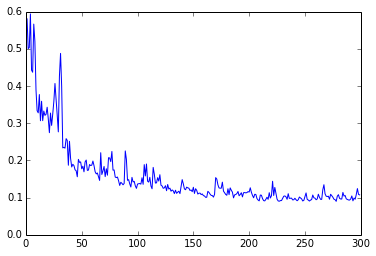

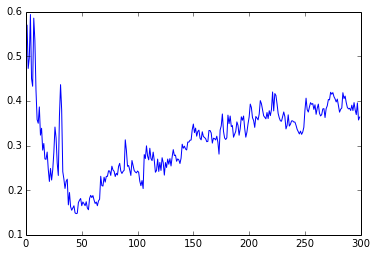

In [70]:
train_errors = []
test_errors = []
for it in range(300):
    learner.run(num_epochs = 1, num_episodes = 10)
    train_errors.append(eval_dataset(dqn, train_tasks))
    test_errors.append(eval_dataset(dqn, test_tasks))
    print 'it', it, 'train_err', train_errors[-1], 'test_err', test_errors[-1]
figure(1)
plot(train_errors)
figure(2)
plot(test_errors)

# Transfer to Another World

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


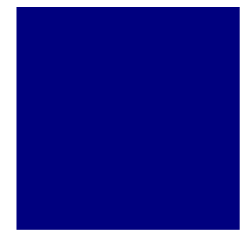

In [46]:
# world 1
H = W = 6
grid1 = np.zeros((H, W))
showV(grid1)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


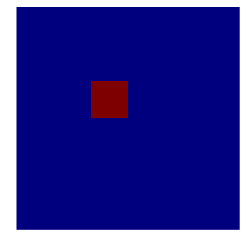

In [47]:
# world 2
H = W = 6
grid2 = np.zeros((H, W))
grid2[2:3, 2:3] = 1.
showV(grid2)

In [56]:
goals = [(1,1), (5,5), (3,4)]

In [57]:
def generate_gridworlds_with_goals(grid, goals):
    all_tasks = generate_gridworlds(grid)
    return [task for task in all_tasks if task.goal.keys()[0] in goals]
tasks1 = generate_gridworlds_with_goals(grid1, goals)
tasks2 = generate_gridworlds_with_goals(grid2, goals)

In [63]:
# evaluation function.
reconV = {}
def eval_dataset(dqn, tasks):
    reward = 0.0
    for task in tasks:
        reward += expected_reward_tabular_normalized(dqn, task, tol=1e-4)
    return reward / len(tasks)

it 0 train_err 0.357517561399
it 1 train_err 0.431958720069
it 2 train_err 0.434637913892
it 3 train_err 0.439086223318
it 4 train_err 0.515047962
it 5 train_err 0.564268973705
it 6 train_err 0.641434219165
it 7 train_err 0.645772771298
it 8 train_err 0.578959125201
it 9 train_err 0.689587862978
it 10 train_err 0.653394912617
it 11 train_err 0.690236901337
it 12 train_err 0.689418002195
it 13 train_err 0.71470194783
it 14 train_err 0.72038036351
it 15 train_err 0.75791155535
it 16 train_err 0.755301670685
it 17 train_err 0.741227892167
it 18 train_err 0.758157670311
it 19 train_err 0.742479416437
it 20 train_err 0.792551839437
it 21 train_err 0.822896929107
it 22 train_err 0.8253874417
it 23 train_err 0.731494336215
it 24 train_err 0.813878225949
it 25 train_err 0.813143550565
it 26 train_err 0.848700970716
it 27 train_err 0.85783510971
it 28 train_err 0.854117631918
it 29 train_err 0.807322709283
it 30 train_err 0.797702129173
it 31 train_err 0.820280578887
it 32 train_err 0.834600617

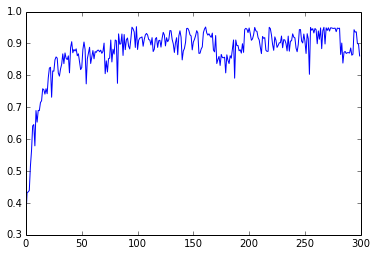

In [64]:
# independently train tasks2
dqn = DQN(tasks2[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
learner = SingleLearnerSequential(dqn, tasks1, lr=1e-4, memory_size=250)
train_errors = []
for it in range(300):
    learner.run(num_epochs = 1, num_episodes = 10)
    train_errors.append(eval_dataset(dqn, tasks2))
    print 'it', it, 'train_err', train_errors[-1]
figure(1)
plot(train_errors)

In [65]:
train_errors_method_1 = train_errors

it 0 train_err 0.333003452614
it 1 train_err 0.499894887816
it 2 train_err 0.570762308585
it 3 train_err 0.672555519323
it 4 train_err 0.780196262789
it 5 train_err 0.677990150566
it 6 train_err 0.703281142329
it 7 train_err 0.718337338511
it 8 train_err 0.702725796568
it 9 train_err 0.736322724728
it 10 train_err 0.706112510807
it 11 train_err 0.767258533778
it 12 train_err 0.833580712705
it 13 train_err 0.782740096593
it 14 train_err 0.753430787973
it 15 train_err 0.769685157221
it 16 train_err 0.829445575574
it 17 train_err 0.833672043902
it 18 train_err 0.799319464786
it 19 train_err 0.805932994636
it 20 train_err 0.794156492493
it 21 train_err 0.776080187276
it 22 train_err 0.809026039835
it 23 train_err 0.789808081846
it 24 train_err 0.738103987047
it 25 train_err 0.806433745228
it 26 train_err 0.842363145603
it 27 train_err 0.852404681792
it 28 train_err 0.821175878672
it 29 train_err 0.800658483948
it 30 train_err 0.774384044181
it 31 train_err 0.804388174579
it 32 train_err 0.

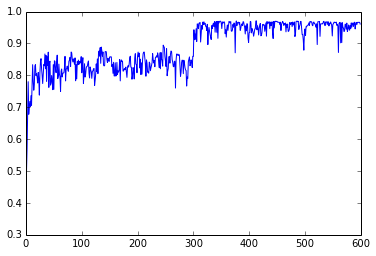

In [68]:
# train task1, then train tasks2
dqn = DQN(tasks1[0], lambda states: arch.two_layer(states, H * W * 2, 32, 4))
learner = SingleLearnerSequential(dqn, tasks1, lr=1e-4, memory_size=250)
errors = []
for it in range(300):
    learner.run(num_epochs = 1, num_episodes = 10)
    errors.append(eval_dataset(dqn, tasks2))
    print 'it', it, 'train_err', errors[-1]
learner = SingleLearnerSequential(dqn, tasks2, lr=1e-4, memory_size=250)
for it in range(300):
    learner.run(num_epochs = 1, num_episodes = 10)
    errors.append(eval_dataset(dqn, tasks2))
    print 'it', it, 'train_err', errors[-1]
figure(1)
plot(errors)